In [104]:
import pandas as pd
import numpy as np

In [105]:
df=pd.read_csv('data/df_ml.csv', sep=",")
#df['Date'] = pd.to_datetime(df['Date'])

#df.drop(index=1, inplace=True)
df.head(3)

,Open,High,Low,Close,Adj Close,Volume($),Symbol,Daily Return,SMA_30,SMA_60,...,Close_rolling_std_7,Volume_rolling_mean_7,Volume_rolling_std_7,Close_rolling_mean_30,Close_rolling_std_30,Volume_rolling_mean_30,Volume_rolling_std_30,Year,Month,Day
0,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,BTC,0.012842,22428.243750,19715.608773,...,1284.059118,4.970113e+10,8.115395e+09,22428.243750,3661.566866,3.886562e+10,1.223869e+10,2021,1,1
1,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,BTC,0.093726,22850.972721,20018.558219,...,1936.633106,5.249153e+10,1.055716e+10,22850.972721,4019.854985,4.006346e+10,1.325301e+10,2021,1,2
2,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,BTC,0.020380,23320.381315,20329.363493,...,2189.909798,5.423229e+10,1.376529e+10,23320.381315,4328.735995,4.155655e+10,1.494648e+10,2021,1,3


In [106]:
#allowed_cryptos = ['BTC', 'ETH', 'USDT', 'BNB', 'SOL', 'XRP', 'ADA', 'AVAX', 'DOGE']
# Filter the DataFrame to include only the rows with symbols in the allowed list
#df = df[df['Symbol'].isin(allowed_cryptos)]

In [107]:
df = df[['Symbol','Close', 'Close_lag_1', 'Low','Midpoint','High','Open','Close_lag_3']] #
#df = df[['Close','Symbol','Close_lag_7','EMA_90', '90_day_MA', 'Close_rolling_mean_30','EMA_60','EMA_26','SMA_30']]
#df.head(1)



28             Close_lag_7        1
12                  EMA_90        1
23               90_day_MA        1
34   Close_rolling_mean_30        1
11                  EMA_60        2
15                  EMA_26        3
7                   SMA_30        4

#### Onehot encoding 

In [109]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

artists_column = df['Symbol'].values.reshape(-1, 1)

one_hot_encoded_artists = one_hot_encoder.fit_transform(artists_column)

df['Symbol'] = np.argmax(one_hot_encoded_artists, axis=1)

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Scaling and Spliting train,test,validation

In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into features (X) and target variable (y)
X = df.drop('Close', axis=1)  
y = df['Close']

# Split the dataset into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)


## Machine Learning Models

### LSTM

In [111]:
lstm_test = df

In [112]:
df

,Symbol,Close,Close_lag_1,Low,Midpoint,High,Open,Close_lag_3
0,3,29374.152344,29001.720703,28803.585938,29202.106445,29600.626953,28994.009766,27362.437500
1,3,32127.267578,29374.152344,29091.181641,31123.149414,33155.117188,29376.455078,28840.953125
2,3,32782.023438,32127.267578,32052.316406,33330.437500,34608.558594,32129.408203,29001.720703
3,3,31971.914062,32782.023438,28722.755859,31081.487305,33440.218750,32810.949219,29374.152344
4,3,33992.429688,31971.914062,30221.187500,32329.388672,34437.589844,31977.041016,32127.267578
...,...,...,...,...,...,...,...,...
16039,10,2.160291,2.135291,2.101517,2.132578,2.163639,2.143799,2.045980
16040,10,2.587086,2.160291,2.156239,2.397342,2.638445,2.159645,2.092255
16041,10,2.539670,2.587086,2.424762,2.578523,2.732283,2.592313,2.135291
16042,10,2.425865,2.539670,2.418916,2.483391,2.547866,2.544140,2.160291


In [113]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)  # Exclude 'Date' if it exists

# Define a function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, -1]  # Assuming the target (e.g., 'Close') is the last column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of time steps to look back 
X, y = create_sequences(scaled_data, seq_length)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [114]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [115]:
# Adjust hyperparameters
hidden_dim = 85  # num LSTM units
num_layers = 4  # Numb LSTM layers
learning_rate = 0.001  # Learning rate for the optimizer
batch_size = 64  # Batch size for training
weight_decay = 1e-5  # L2 regularization term
output_dim = 1

input_dim = X_train.shape[2]

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

#  optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

# Define a DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Training loop with batch processing and gradient clipping
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()
    
    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 8.006490679690614e-05
Epoch 10, Loss: 1.533276736154221e-05
Epoch 20, Loss: 1.8600496787257725e-06
Epoch 30, Loss: 1.5849660485400818e-05
Epoch 40, Loss: 6.932092946954072e-05
Epoch 50, Loss: 4.6895329433027655e-05
Epoch 60, Loss: 3.1698069506092e-05
Epoch 70, Loss: 8.322668691107538e-06
Epoch 80, Loss: 0.00013949743879493326
Epoch 90, Loss: 2.6881130906986073e-05
Epoch 100, Loss: 2.722398676269222e-05
Epoch 110, Loss: 6.529129450427718e-07
Epoch 120, Loss: 0.00011001912935171276
Epoch 130, Loss: 3.7860643260501092e-06
Epoch 140, Loss: 0.00014458644727710634
Epoch 150, Loss: 3.0886692456988385e-06
Epoch 160, Loss: 7.65440836403286e-06
Epoch 170, Loss: 4.070855720783584e-05
Epoch 180, Loss: 0.00015450399951077998
Epoch 190, Loss: 4.067173722432926e-05


In [116]:
# validation
model.eval()
predicted = model(X_test)
predicted = predicted.detach().numpy()
actual = y_test.numpy()

# You can use any metric for evaluation, here we use Mean Squared Error as an example
test_loss = criterion(model(X_test), y_test)
print(f'Test Loss: {test_loss.item()}')



Test Loss: 6.401418062296216e-08


In [117]:
predicted_reshaped = np.zeros((len(predicted), scaled_data.shape[1]))  

actual_reshaped = np.zeros((len(actual), scaled_data.shape[1]))
actual_reshaped[:, -1] = actual.squeeze()


predicted_inverse = scaler.inverse_transform(predicted_reshaped)[:, -1]  
actual_inverse = scaler.inverse_transform(actual_reshaped)[:, -1]



In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mae = mean_absolute_error(actual_inverse, predicted_inverse)
rmse = np.sqrt(mean_squared_error(actual_inverse, predicted_inverse))
# MAPE function needs to handle division by zero, so we'll define it manually
mape = np.mean(np.abs((actual_inverse - predicted_inverse) / actual_inverse)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Absolute Error (MAE): 16.140762667778052
Root Mean Squared Error (RMSE): 17.095097462538067
Mean Absolute Percentage Error (MAPE): 2432.4816805242285%


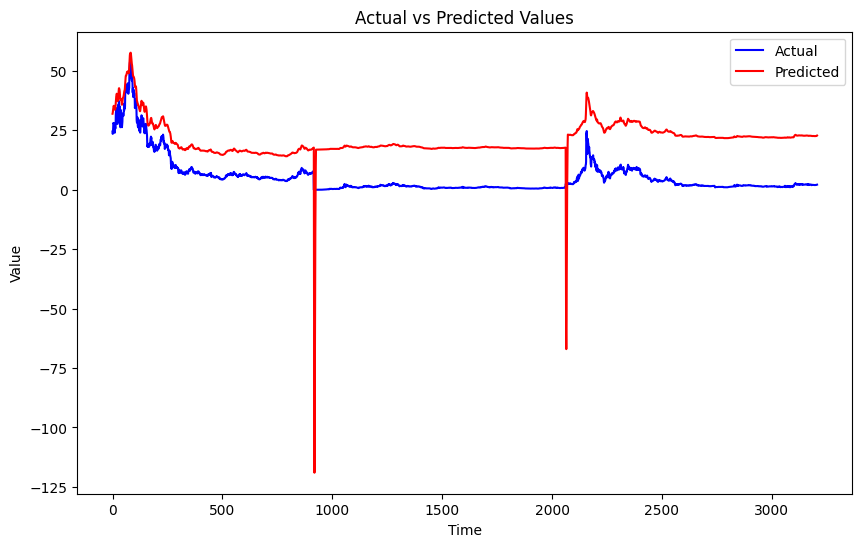

In [119]:
import matplotlib.pyplot as plt

# Assuming 'actual_inverse' and 'predicted_inverse' are your actual and predicted values respectively
plt.figure(figsize=(10,6))
plt.plot(actual_inverse, label='Actual', color='blue')
plt.plot(predicted_inverse, label='Predicted', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [103]:
#stop


### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_reg = LinearRegression()

linear_reg.fit(X_train_scaled, y_train)

# test set
y_pred = linear_reg.predict(X_test_scaled)

mse_lr = mean_squared_error(y_test, y_pred)
print(f"Linear Regression MSE: {mse_lr}")


In [24]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.9998187610689385
Mean Absolute Error (MAE): 30.318067887842968
Root Mean Squared Error (RMSE): 141.21708306492204


##### Cross-Validation for Linear Regression

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()

#  cross-validation
cv_scores_lr = cross_val_score(linear_reg, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean MSE
mean_mse_lr = -cv_scores_lr.mean()
print(f"Linear Regression Cross-Validated MSE: {mean_mse_lr}")


Linear Regression Cross-Validated MSE: 21423.389740088758


#### Grid Search
Grid Search evaluates all the provided combinations of hyperparameters, which can be computationally expensive but thorough.

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

#  parameters
param_dist = {
    'n_estimators': [80, 100, 120, 140],
    'max_depth': [20, 30, 40, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

#base model
rf = RandomForestRegressor(random_state=42)

# Initialize the randomized search model
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1,
                                   scoring='neg_mean_squared_error')

# Fit the randomized search model
random_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", np.sqrt(-random_search.best_score_))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Best score found:  195.77046215036302


In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
model = RandomForestRegressor(random_state=42)

param_distributions = {
    'n_estimators': randint(100, 500),  # Number of trees in the forest
    'max_depth': randint(10, 50),  # Maximum depth of the tree
    'min_samples_split': randint(2, 11),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 11),  # Minimum number of samples required to be at a leaf node
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    verbose=2,  
    random_state=42,
    n_jobs=-1,  # Number of jobs to run in parallel (-1 means using all processors)
    scoring='neg_mean_squared_error' 
)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", -random_search.best_score_)

best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 275}
Best score found:  38651.833918261735
Test MSE: 34268.50814304979


In [33]:
#  R-squared
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.9996885615588167
Mean Absolute Error (MAE): 41.22077809745639
Root Mean Squared Error (RMSE): 185.11755222844155


In [ ]:
y_pred_independent = random_forest.predict(X_independent_test_scaled)

# Calculate metrics
mse_independent = mean_squared_error(y_independent_test, y_pred_independent)
r2_independent = r2_score(y_independent_test, y_pred_independent)
mae_independent = mean_absolute_error(y_independent_test, y_pred_independent)

print(f"Independent Test MSE: {mse_independent}")
print(f"Independent Test R-squared: {r2_independent}")
print(f"Independent Test MAE: {mae_independent}")


In [34]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# parameters
model = RandomForestRegressor(
    max_depth=12, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=275,
    random_state=42)

mse_scores = []
r2_scores = []
mae_scores = []

for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")


Average MSE: 504017.42934379855
Average R-squared: -17.12640306626498
Average MAE: 211.3903191462378


### Decision Trees and Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#  parameters from Grid Search
random_forest = RandomForestRegressor(
    n_estimators=120,  #  number of trees
    max_depth=30,  #  maximum depth of trees
    min_samples_leaf=1,  #  minimum number of samples required at a leaf node
    min_samples_split=2,  #  minimum number of samples required to split an internal node
    random_state=42  # For reproducibility
)

random_forest.fit(X_train_scaled, y_train)


y_pred_rf = random_forest.predict(X_test_scaled)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE with Best Parameters: {mse_rf}")




Random Forest MSE with Best Parameters: 33160.30784583442


In [32]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Calculate R-squared
r_squared = r2_score(y_test, y_pred_rf)
print(f"R-squared: {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_rf)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.999698633084885
Mean Absolute Error (MAE): 40.328240554986756
Root Mean Squared Error (RMSE): 182.09971951058688


##### Cross-Validation for Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores_rf = cross_val_score(random_forest, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean MSE
mean_mse_rf = -cv_scores_rf.mean()
print(f"Random Forest Cross-Validated MSE: {mean_mse_rf}")


Random Forest Cross-Validated MSE: 96922514.69028388


### Gradient Boosting Machines (GBM)

#### Random Search
Random Search samples a given number of candidates from a parameter space with a specified distribution. It's less comprehensive but much faster than Grid Search.

In [223]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the parameter 
param_dist = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.3, 0.7],
    'subsample': [0.6, 0.9]
}

# Initialize the XGBRegressor
xg_reg = xgb.XGBRegressor()

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg_reg, param_distributions=param_dist, n_iter=25, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", -random_search.best_score_)


Best parameters found:  {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best score found:  39292.73854500158


In [234]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Adjusting the model with the best parameters found
xg_reg_optimized = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.7,   
    learning_rate=0.1,      
    max_depth=5,           
    alpha=10,              
    n_estimators=500,      
    subsample=0.8          
)

# Fit the model  
xg_reg_optimized.fit(X_train_scaled, y_train)

 
y_pred_optimized = xg_reg_optimized.predict(X_test_scaled)

# Evaluate the model  
mse_xgb_optimized = mean_squared_error(y_test, y_pred_optimized)
print(f"Optimized XGBoost MSE: {mse_xgb_optimized}")


Optimized XGBoost MSE: 32797.58750307243


In [235]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Calculate R-squared
r_squared = r2_score(y_test, y_pred_optimized)
print(f"R-squared: {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_optimized)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.9997019295533995
Mean Absolute Error (MAE): 39.37663597807381
Root Mean Squared Error (RMSE): 181.10104224733888


##### Cross-Validation for XGBoost

In [236]:
import xgboost as xgb

# Initialize the model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                max_depth=5, alpha=10, n_estimators=10)

# Perform cross-validation
cv_scores_xgb = cross_val_score(xg_reg, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean MSE
mean_mse_xgb = -cv_scores_xgb.mean()
print(f"XGBoost Cross-Validated MSE: {mean_mse_xgb}")


XGBoost Cross-Validated MSE: 98328661.26877618


### LazyPredict

In [13]:
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle

 
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and compare models
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the performance of each model
print(models)


 74%|███████▍  | 31/42 [01:05<00:13,  1.18s/it]

In [ ]:
df.to_csv('data/df_fs.csv', index=False)